In [7]:
import pandas as pd
import numpy as np
import cPickle as pickle
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import interp
from itertools import cycle

from sklearn import metrics
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, precision_recall_curve, average_precision_score, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.semi_supervised import label_propagation
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline

def cross_val_roc(classifier, X, y, n_splits=3, balance=False, test_size=0.25):
    # Run classifier with cross-validation and plot ROC curves
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
    lw = 2
    plt.clf()
    plt.figure(figsize=(8,6));
    
    if balance:
        splits = StratifiedShuffleSplit(y, n_splits, test_size=test_size)
    else:
        splits = StratifiedKFold(n_splits=n_splits).split(X, y)
    
    i = 0
    for (train, test), color in zip(splits, colors):
        X_train, X_test = X.ix[train], X.ix[test]
        y_train, y_test = y.ix[train], y.ix[test]
        if balance:
            X_train, y_train = balance_train_index(X_train, y_train)
        
        probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw, color=color,
                 label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
             label='Luck')

    mean_tpr /= n_splits
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show();

def cv_score(clf, X, y, cv=5, scoring='f1'):
    print scoring + ' cross validation score: ' + str(np.mean(cross_val_score(rf, X, y, cv=cv, scoring=scoring)))
    
def combine_and_balance_dfs(df1, df2, minority_fraction=0.5, ignore_index=True):
    if df1.shape[0] > df2.shape[0]:
        df1, df2 = df2, df1
    m = int(df1.shape[0]*(1.0/minority_fraction - 1))
    if m > df2.shape[0]:
        print 'majority df too small to achieve desired minority fraction'
        m = df2.shape[0]
    return df1.append(df2.sample(m), ignore_index=ignore_index)

def balance_train_index(X_train, y_train):
    pos_index = y_train[y_train == 1].index
    neg_index = y_train[y_train == 0].index
    reduced_neg_index = np.random.choice(neg_index, pos_index.shape[0], replace=False)
    b_index = pos_index.tolist() + reduced_neg_index.tolist()
    return X_train.ix[b_index], y_train.ix[b_index]

#Balances training split but not testing split
def balanced_train_test_split(X, y, test_size=0.5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, y_train = balance_train_index(X_train, y_train)
    return X_train, X_test, y_train, y_test

def plot_multiple_precision_recall_curves(y_true, y_pred_probas, baseline=0):
    plt.clf();
    n_rows = len(y_true)/2 if len(y_true) % 2 == 0 else len(y_true)/2 + 1
    fig, axes = plt.subplots(n_rows, 2, figsize=(20,20))
    for ax, tup in zip(axes.flatten(), zip(y_true, y_pred_probas)):
        yt, yp = tup   
        precision, recall, _ = precision_recall_curve(yt, yp)
        avg_precision = average_precision_score(yt, yp)
        ax.plot(recall, precision, color='navy', label='Precision-Recall curve');
        ax.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_ylim([0.0, 1.05])
        ax.set_xlim([0.0, 1.0])
        ax.set_title('Precision-Recall example: AUC={0:0.2f}'.format(avg_precision))
        ax.legend(loc="lower left")
    plt.show();

def plot_precision_recall_curve(y_true, y_pred_probas, baseline=0):
    plt.clf();
    plt.figure(figsize=(8,6));
    precision, recall, _ = precision_recall_curve(y_true, y_pred_probas)
    avg_precision = average_precision_score(y_true, y_pred_probas)
    plt.plot(recall, precision, color='navy', label='Precision-Recall curve');
    plt.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example: AUC={0:0.2f}'.format(avg_precision))
    plt.legend(loc="lower left")
    plt.show();

def rebalance_df(df, minority_fraction=0.5):
    pos_df = df[df['allergen'] == 1]
    neg_df = df[df['allergen'] == 0]
    return combine_and_balance_dfs(pos_df, neg_df, minority_fraction=minority_fraction)

def df_ratio(df):
    return df[df['allergen'] == 1].shape[0]*1.0/df.shape[0]

In [46]:
with open('pickles/full_ABT_df.pkl', 'r') as fin:
    df = pickle.load(fin)

In [47]:
percents = [0.004, 0.007, 0.01, 0.05, 0.2, 0.4, 0.5]
percent_dfs = []
for p in percents:
    percent_dfs.append(rebalance_df(df, minority_fraction=p))

sdf = df.sample(50000).reset_index(drop=True)

In [48]:
print df_ratio(df)
print df_ratio(sdf)
for percent_df in percent_dfs:
    print df_ratio(percent_df)

0.00283653147693
0.00286
0.004
0.00700003526466
0.01
0.05
0.2
0.400067181727
0.5


In [49]:
for i in range(df.shape[0]):
    for a in df.ix[i]:
        if a == np.nan:
            print df.ix[i]
            break

KeyboardInterrupt: 

## balanced versus unbalanced training

In [52]:
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
nb = Pipeline([('vect', TfidfVectorizer(analyzer='char', ngram_range=(1,4))), ('nb', MultinomialNB())])

def evaluate_models(tests, classifiers, balance=False):
    for X, y, m in tests:
        for bal in list(balance):
            for clf in classifiers:
                print '\n\n', m
                print 'balanced training data: ', str(bal)
                print str(clf).split('(')[0]
                if bal:
                    X_train, X_test, y_train, y_test = balanced_train_test_split(X, y, test_size=.25)
                else:
                    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5)
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                y_pred_proba = clf.predict_proba(X_test)
                print 'f1 score: ', f1_score(y_test, y_pred)
                print 'allergens in y_test and y_pred: ', sum(y_test), sum(y_pred)
                plot_precision_recall_curve(y_test, y_pred_proba[:, 1], baseline=m[0])
                cross_val_roc(clf, X, y)
                print '\n\n'



('0.00283653147693', 'df')
balanced training data:  True
RandomForestClassifier
f1 score:  0.0318160550765


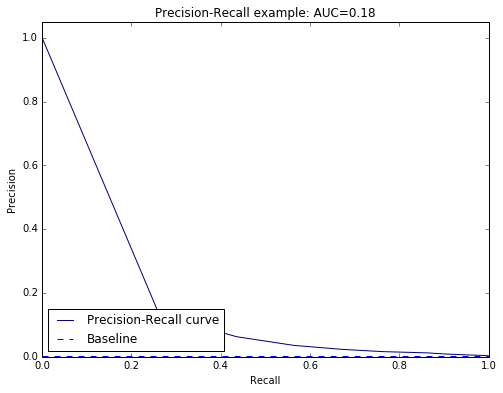

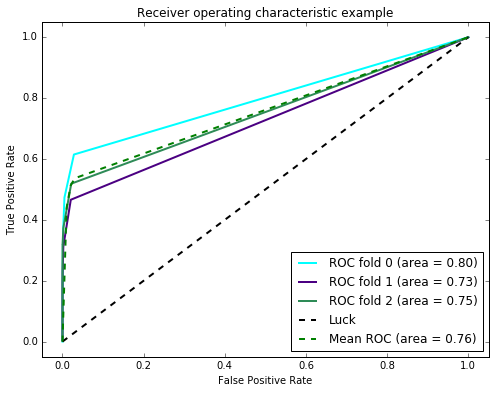






('0.00283653147693', 'df')
balanced training data:  True
GradientBoostingClassifier
f1 score:  0.0312314451965


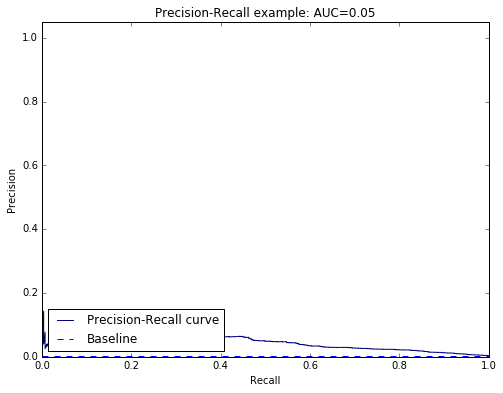

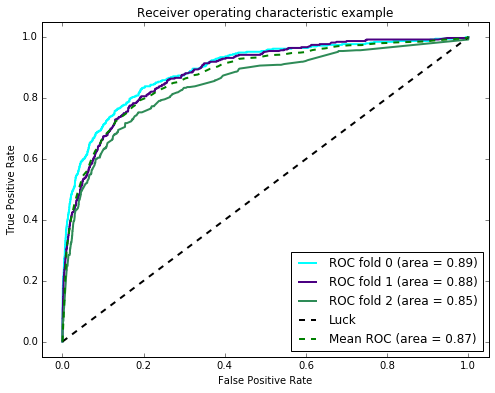






('0.00283653147693', 'df')
balanced training data:  False
RandomForestClassifier
f1 score:  0.152694610778


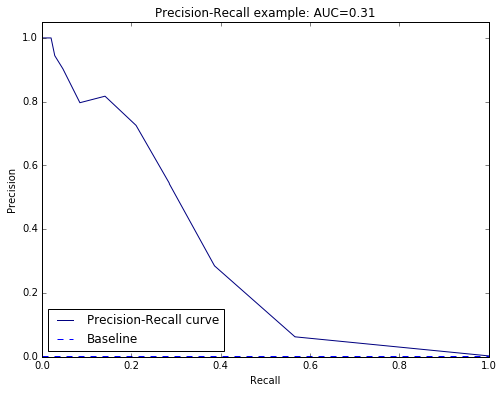

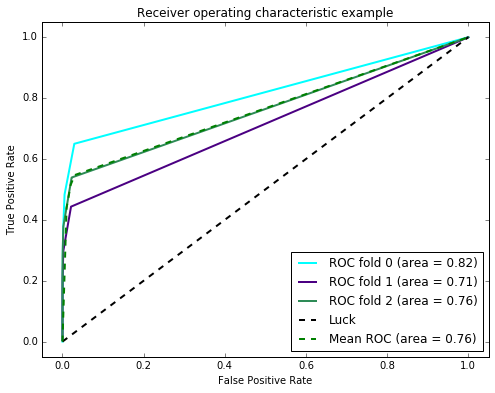






('0.00283653147693', 'df')
balanced training data:  False
GradientBoostingClassifier
f1 score:  0.143826322931


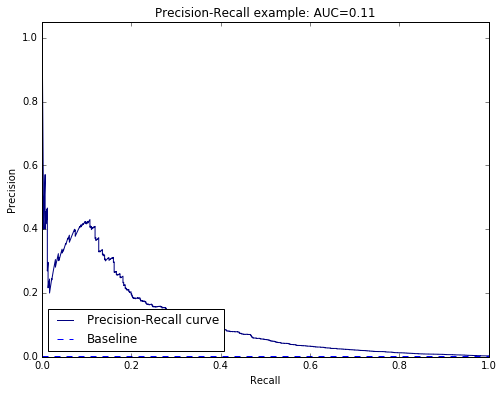

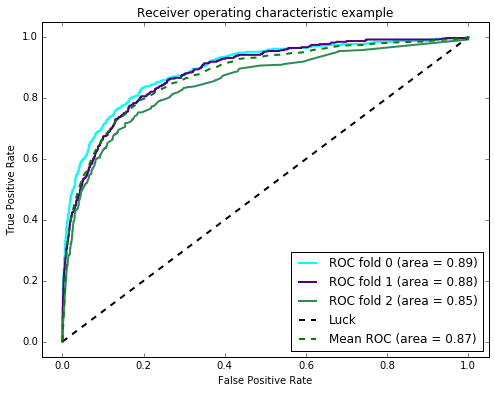

In [51]:
X = df.drop(['sequence','allergen'], axis=1)
y = df['allergen'].copy()
m = (str(df_ratio(df)), 'df')

classifiers = [rf, gb]

tests = [(X, y, m)]

# for percent_df in percent_dfs:
#     X = percent_df.drop(['sequence','allergen'], axis=1)
#     y = percent_df['allergen'].copy()
#     m = str(df_ratio(percent_df)), ' percent df'
#     tests.append((X, y, m))

evaluate_models(tests, classifiers, balance=[True, False])



('0.00286', 'sdf')
balanced training data:  True
Pipeline
f1 score:  0.17955801105
allergens in y_test and y_pred:  301 1871


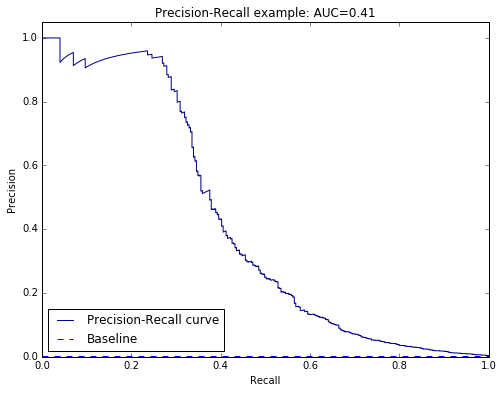

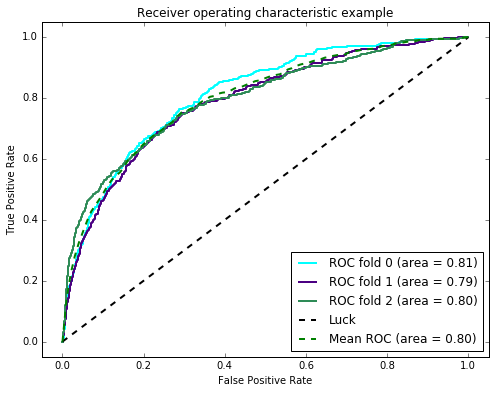






('0.00286', 'sdf')
balanced training data:  False
Pipeline
f1 score:  0.0
allergens in y_test and y_pred:  600 14


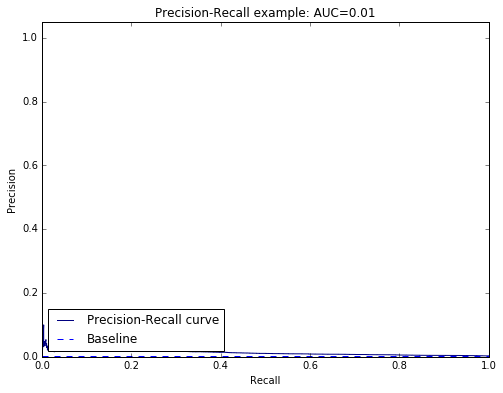

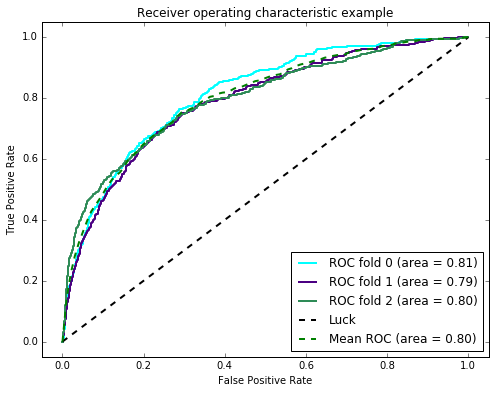

In [55]:
X = df['sequence'].copy()
y = df['allergen'].copy()
m = (str(df_ratio(sdf)), 'sdf')
classifiers = [nb]
tests = [(X, y, m)]

# for percent_df in percent_dfs[-4:]:
#     X = percent_df['sequence'].copy()
#     y = percent_df['allergen'].copy()
#     m = str(df_ratio(percent_df)), ' percent df'
#     tests.append((X, y, m))

evaluate_models(tests, classifiers, balance=[True, False])

## One class SVM

# forgot to scale data!

In [ ]:
X = sdf.drop(['sequence','allergen'], axis=1)
y = sdf['allergen'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5)
X_train = X_train[y_train == 1];
y_train = y_train[y_train == 1]

X_unlabeled = X_test[y_test == 0]
y_unlabeled = y_test[y_test == 0]

ss = StandardScaler(with_mean=False)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
X_unlabeled = ss.transform(X_unlabeled)

clf = svm.OneClassSVM(nu=0.2, kernel="rbf", gamma=0.0009765625)
clf.fit(X_train)

y_pred_train = clf.predict(X_train)
y_train_scores = clf.decision_function(X_train)
y_pred_test = clf.predict(X_test)
y_test_scores = clf.decision_function(X_test)
n_error_train = y_pred_train[y_pred_train == -1].size

y_pred_unlabeled = clf.predict(X_unlabeled)
y_unlabeled_scores = clf.decision_function(X_unlabeled)

y_pred_unlabeled_pos = y_pred_unlabeled[y_pred_unlabeled == 1]
y_pred_unlabeled_pos_prop = y_pred_unlabeled_pos.shape[0]*1.0/y_pred_unlabeled.shape[0]

print 'training size: ', X_train.shape[0]
# print 'test size', X_test.shape[0]
# print 'unlabeled size: ', X_unlabeled.shape[0]
print 'train error proportion: ', 1.0*n_error_train/X_train.shape[0]
print 'unlabeled positive proportion: ', y_pred_unlabeled_pos_prop

#doesn't do anything if both y_train and y_test are all positives
y_test = y_test.apply(lambda x: -1.0 if x == 0 else 1.0)
y_train = y_train.apply(lambda x: -1.0 if x == 0 else 1.0)

print classification_report(y_test, y_pred_test)
plot_precision_recall_curve(y_test, y_test_scores)

In [ ]:
X = sdf.drop(['sequence','allergen'], axis=1).copy()
y = sdf['allergen'].copy()
clf = svm.OneClassSVM(nu=0.10, kernel="rbf", gamma=0.1)
parameters = {'kernel':('rbf',), 'nu':[0.001, 0.01, 0.1, 0.2, 0.4, 0.6], 'gamma': [2**(-10), 2**(-5), 0.1, 1, 2, 8]}
gs_clf = GridSearchCV(clf, parameters, scoring='f1')
gs_clf.fit(X, y)
print gs_clf.best_score_, gs_clf.best_params_

## Semi-Supervised Learning

### label prop

In [ ]:
X = sdf.drop(['sequence','allergen'], axis=1)
y = sdf['allergen'].copy()
unlabeled_set = y == 0
y_train = y.copy()
y_train[unlabeled_set] = -1
print X.shape, y_train.shape, unlabeled_set.shape, y_train[y_train == 1].shape

# lp_model = label_propagation.LabelSpreading(gamma=0.25, max_iter=5)
lp_model = label_propagation.LabelPropagation()
lp_model.fit(X, y_train)
predicted_labels = lp_model.predict_proba(X)
true_labels = y[unlabeled_set]

cm = confusion_matrix(true_labels, predicted_labels, labels=lp_model.classes_)

print("Label Spreading model: %d labeled & %d unlabeled points (%d total)" %
      (n_labeled_points, n_total_samples - n_labeled_points, n_total_samples))

print(classification_report(true_labels, predicted_labels))

print("Confusion matrix")
print(cm)

### two-step

In [ ]:
from sklearn.neighbors.nearest_centroid import NearestCentroid
nc = NearestCentroid(metric='cosine', shrink_threshold=0.2)
X = sdf.drop(['sequence','allergen'], axis=1)
y = sdf['allergen'].copy()

nc.fit(X, y)
pred = nc.

## Ensemble

# Naive Bayes

In [108]:
clf = Pipeline([('vect', TfidfVectorizer(analyzer='char', ngram_range=(1,3))), ('nb', MultinomialNB())])
X = balanced_df['sequence']
y = balanced_df['allergen'].copy()

# vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1,3))
# X = vectorizer.fit_transform(X)

In [109]:
print cross_val_score(clf, X, y, cv=3, scoring='f1')

[ 0.73267327  0.69710807  0.74251497]


# Playground

In [53]:
# def test_plot(x, y, ax):
#     ax.plot(x, y)
#     ax.set_xlabel('yup')

# def multi(x, y):
#     plt.clf();
#     n_rows = len(x)/2 if len(x) % 2 == 0 else len(x)/2 + 1
#     fig, axes = plt.subplots(n_rows, 2, figsize=(20,20))
#     for ax, tup in zip(axes.flatten(), zip(x, y)):
#         test_plot(tup[0], tup[1], ax)
#     plt.show()
#     plt.
    
# x = [[1,2],[3,4], [9,10]]*2
# y = [[5,6], [7,8], [11,12]]*2
# multi(x,y)

In [56]:
X = sdf.drop(['sequence','allergen'], axis=1)
y = sdf['allergen'].copy()
clf = GradientBoostingClassifier()
param_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
              'max_depth': [3, 5],
              'min_samples_leaf': [3, 5, 9, 17],
              'n_estimators': [100, 500]
              }
gs_clf = GridSearchCV(clf, param_grid, scoring='f1')
gs_clf.fit(X, y)
print gs_clf.best_score_, gs_clf.best_params_

/Users/Jake1/anaconda/lib/python2.7/site-packages/sklearn/ensemble/gradient_boosting.py:517: RuntimeWarning: overflow encountered in double_scalars
  tree.value[leaf, 0, 0] = numerator / denominator
/Users/Jake1/anaconda/lib/python2.7/site-packages/sklearn/ensemble/gradient_boosting.py:490: RuntimeWarning: invalid value encountered in multiply
  np.sum(sample_weight * ((y * pred) - np.logaddexp(0.0, pred))))
/Users/Jake1/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.202511041667 {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 17}
